<a href="https://colab.research.google.com/github/bennettJG/data17200project/blob/main/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load preprocessed data from part 1

import zipfile, io, pickle
from urllib.request import urlopen

r = urlopen("https://github.com/bennettJG/data17200project/raw/refs/heads/main/preprocessed_data.zip")
#print(r)
z = zipfile.ZipFile(io.BytesIO(r.read()))
z.extractall()

with open("preprocessed_data.pkl", "rb") as input_file:
  X_train_scaled, X_test_scaled, y_train, y_test = pickle.load(input_file)

In [ ]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

random_state=1701

In [ ]:
from sklearn.metrics import make_scorer

def calculate_cv_metrics(model, X, y, pos_label):
  kfold = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state = random_state)
  cv_score = cross_validate(model, X, y, cv=kfold, scoring = {'acc': make_scorer(accuracy_score),
                                                              'prec': make_scorer(precision_score, average=None, labels=[pos_label]),
                                                              'rec': make_scorer(recall_score, average=None, labels=[pos_label]),
                                                              'fone': make_scorer(f1_score, average=None, labels=[pos_label])})
  results = {'Avg accuracy': np.mean(cv_score['test_acc']).round(4),
             'Avg precision': np.mean(cv_score['test_prec']).round(4),
             'Avg recall': np.mean(cv_score['test_rec']).round(4),
             'Avg F1 score':np.mean(cv_score['test_fone']).round(4)}
  for score, val in results.items():
    print(f'{score}: {val}\n')
  return results

def grid_recall(model, X, y, pos, param_grid):
  kfold = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state = random_state)
  grid = GridSearchCV(model, cv=kfold, scoring = make_scorer(recall_score, average=None, labels=[pos], pos_label=pos), param_grid=param_grid, error_score='raise')
  grid.fit(X, y)
  print(f"The best parameters are {grid.best_params_} with a recall of {grid.best_score_:.4f} for readmission within 30 days.")
  return grid

def calculate_test_metrics(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f'Classification report:\n')
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Target Value Distribution

The target values are highly unbalanced, particularly for the value we care most about (readmission within 30 days).

<Axes: xlabel='readmit_less30'>

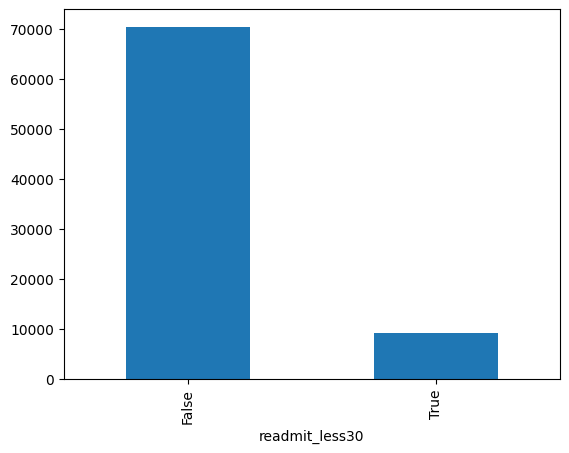

In [ ]:
y_train['readmit_less30'].value_counts().plot.bar(x='readmit_less30')

<Axes: xlabel='readmitted'>

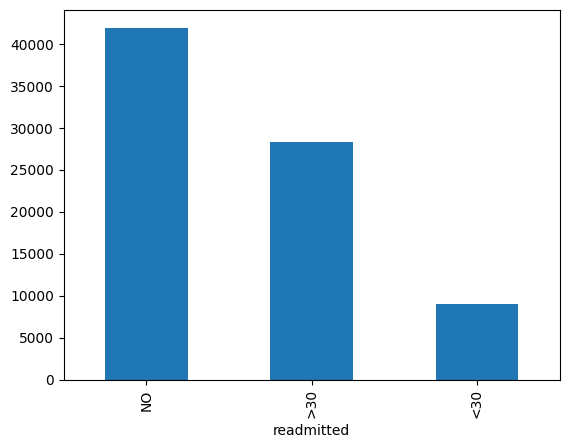

In [ ]:
y_train['readmitted'].value_counts().plot.bar(x='readmitted')

# Model fitting

Given how unbalanced the target values are, I'd prefer to use models that can take the `class_weight='balanced'` parameter, which weights observations based on the rarity of the target value. This improves predictions for less common target classes, and in this particular case the class we care most about -- readmission within 30 days -- is very uncommon. Without accounting for the imbalance, many models will simply assign most/all observations to the more common class, resulting in a very high accuracy but very low recall in the case we most care about.

Models which work with `class_weight='balanced'` include logistic regression, decision trees, random forests, and support vector machines (SVM). I chose to use **logistic regression and random forest** models. I initially attempted to fit an SVM (with the default RBF kernel) as well, but it was impractically slow on my low-powered home computer (the base model, without cross-validation, had still not finished training after nearly an hour).

For each model, I began by testing both multi-class and binary classification, to see whether attempting to additionally predict readmission in more than 30 days detracted from the quality of predictions for the most important outcome of readmission within 30 days.

## With default hyperparameters
### Multi-class

In [ ]:
#X_train_scaled = X_train_scaled.drop(X_train_scaled.loc[:,X_train_scaled.columns.str.contains("repaglinide|glipizide|nateglinide|acarbose|glyburide|glimepiride")], axis=1)
#X_test_scaled = X_test_scaled.drop(X_test_scaled.loc[:,X_test_scaled.columns.str.contains("repaglinide|glipizide|nateglinide|acarbose|glyburide|glimepiride")], axis=1)
#pd.DataFrame(X_train_scaled.columns)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report:

              precision    recall  f1-score   support

         <30       0.19      0.40      0.26      2271
         >30       0.47      0.38      0.42      7105
          NO       0.66      0.59      0.62     10625

    accuracy                           0.49     20001
   macro avg       0.44      0.46      0.43     20001
weighted avg       0.54      0.49      0.51     20001



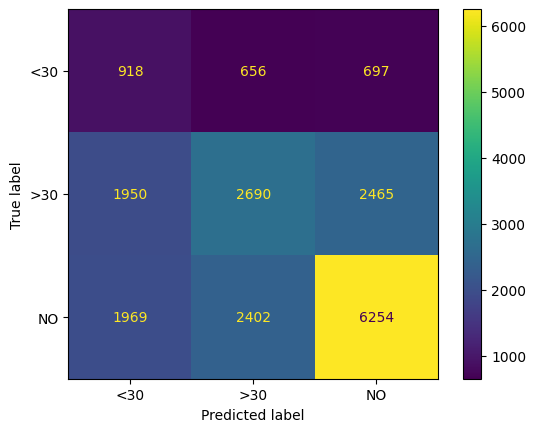

In [ ]:
logistic_multiclass = LogisticRegression(random_state=random_state, class_weight='balanced')

calculate_test_metrics(logistic_multiclass, X_train_scaled, X_test_scaled, y_train['readmitted'], y_test['readmitted'])

Classification report:

              precision    recall  f1-score   support

         <30       0.43      0.03      0.05      2271
         >30       0.50      0.38      0.43      7105
          NO       0.61      0.82      0.70     10625

    accuracy                           0.58     20001
   macro avg       0.51      0.41      0.39     20001
weighted avg       0.55      0.58      0.53     20001



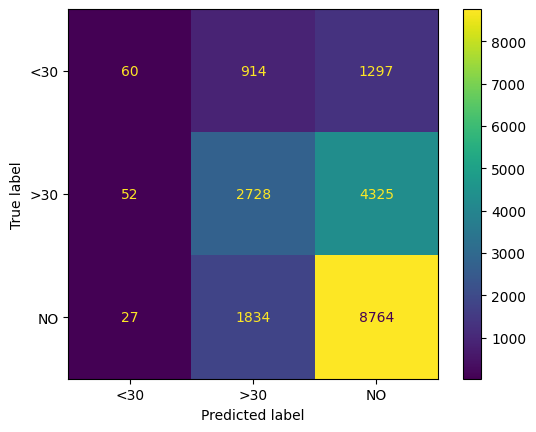

In [ ]:
rf_multiclass = RandomForestClassifier(random_state=random_state, class_weight='balanced')
calculate_test_metrics(rf_multiclass, X_train_scaled, X_test_scaled, y_train['readmitted'], y_test['readmitted'])

Here, the random forest model performs very poorly on the test set, predicting very few readmissions within 30 days regardless of the true label. This is likely a result of overfitting the test data.

The overall accuracy for the logistic regression model is lower, but it performs significantly better than RF in predicting readmission within 30 days. However, the recall for this category is still quite low at 0.40 (less than half the observations which should have been classified in this category actually were). This model does worse in predicting the "no readmission" category (that is, there is a high rate of false positive readmission predictions).

### Binary classification

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report:

              precision    recall  f1-score   support

       False       0.92      0.67      0.78     17730
        True       0.18      0.56      0.27      2271

    accuracy                           0.66     20001
   macro avg       0.55      0.62      0.53     20001
weighted avg       0.84      0.66      0.72     20001



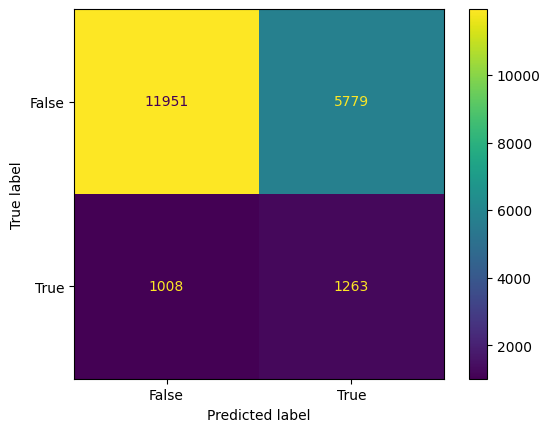

In [ ]:
logistic_binary = LogisticRegression(random_state=random_state, class_weight='balanced')
calculate_test_metrics(logistic_binary, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

Classification report:

              precision    recall  f1-score   support

       False       0.93      0.57      0.71     17730
        True       0.17      0.69      0.27      2271

    accuracy                           0.58     20001
   macro avg       0.55      0.63      0.49     20001
weighted avg       0.85      0.58      0.66     20001



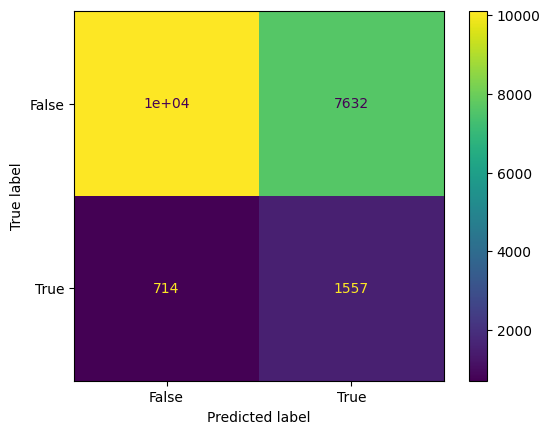

In [ ]:
#!pip install xgboost
from xgboost import XGBClassifier
xgb_binary = XGBClassifier(random_state=random_state, scale_pos_weight = 9, learning_rate=.04, max_depth=6, reg_lambda=10)
calculate_test_metrics(xgb_binary, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

Classification report:

              precision    recall  f1-score   support

       False       0.89      1.00      0.94     17730
        True       0.57      0.01      0.02      2271

    accuracy                           0.89     20001
   macro avg       0.73      0.50      0.48     20001
weighted avg       0.85      0.89      0.84     20001



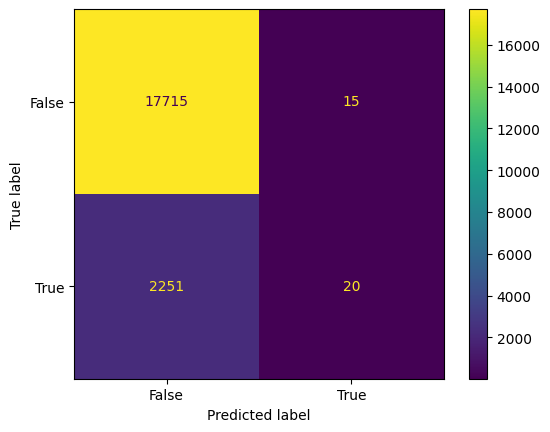

In [ ]:
rf_binary = RandomForestClassifier(random_state=random_state, class_weight='balanced')
calculate_test_metrics(rf_binary, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

The random forest model performs even worse on the binary classification task under default settings, with a recall score of only 1% (!!) on the rare class we care most about. Logistic regression achieves 56% recall for readmission within 30 days, which is better than the 40% obtained in multiclass classification, and considerably better than the ~10% obtainable by chance. However, it is still much lower than would be desirable for an algorithm to be used in a clinical context, and the false positive rate (around a third of patients not readmitted within 30 days are flagged as likely to be) also leaves much to be desired.

## Cross-validation on full dataset

The base options for cross-validation precision, recall, and accuracy scoring assume either that all classes are equally important to classify correctly (`micro`, `macro`) or that classes with more support should be weighted more heavily (`weighted`). Because we care primarily about the rarest class, this is specified using `make_scorer` when defining the `calculate_cv_metrics` function above.

In [ ]:
calculate_cv_metrics(logistic_multiclass, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmitted'], y_test['readmitted']]), pos_label = "<30");

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Avg accuracy: 0.4961

Avg precision: 0.1948

Avg recall: 0.4117

Avg F1 score: 0.2644



In [ ]:
calculate_cv_metrics(rf_multiclass, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmitted'], y_test['readmitted']]), pos_label = "<30");

Avg accuracy: 0.5763

Avg precision: 0.395

Avg recall: 0.0209

Avg F1 score: 0.0396



In [ ]:
calculate_cv_metrics(logistic_binary, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmit_less30'], y_test['readmit_less30']]), pos_label = True);

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Avg accuracy: 0.6562

Avg precision: 0.1774

Avg recall: 0.5583

Avg F1 score: 0.2693



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
calculate_cv_metrics(rf_binary, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmit_less30'], y_test['readmit_less30']]), pos_label = True);

Avg accuracy: 0.8867

Avg precision: 0.5345

Avg recall: 0.0083

Avg F1 score: 0.0163



As with the single train-test run, we see in cross-validation that using default settings, logistic regression significantly outperforms random forest for correctly predicting readmission in under 30 days (recall score), suggesting overfitting issues with the RF model. While logistic regression outperforms chance given the class imbalance, it nonetheless leaves much to be desired.

# Hyperparameter Tuning

In [ ]:
import warnings
warnings.filterwarnings("ignore")
grid_recall(logistic_multiclass, X_train_scaled, y_train['readmitted'], pos="<30", param_grid={'C': [0.1, 0.25, 0.5, 1, 2]})

The best parameters are {'C': 1} with a recall of 0.4052 for readmission within 30 days.


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1701, test_size=0.2,
            train_size=None),
             error_score='raise',
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=1701),
             param_grid={'C': [0.1, 0.25, 0.5, 1, 2]},
             scoring=make_scorer(recall_score, response_method='predict', average=None, labels=['<30'], pos_label=<30))

In [ ]:
grid_rf_mult = grid_recall(rf_multiclass, X_train_scaled, y_train['readmitted'], pos="<30", param_grid={'n_estimators': [25, 50, 100, 200], 'max_depth':[7, 10, 15, 20]})

The best parameters are {'max_depth': 7, 'n_estimators': 100} with a recall of 0.4761 for readmission within 30 days.


In [ ]:
grid_logistic_bin = grid_recall(logistic_binary, X_train_scaled, y_train['readmit_less30'], pos=True, param_grid={'C': [0.5, 1, 2, 3.5, 5]})

The best parameters are {'C': 2} with a recall of 0.5588 for readmission within 30 days.


In [ ]:
grid_rf_bin = grid_recall(rf_binary, X_train_scaled, y_train['readmit_less30'], pos=True, param_grid={'n_estimators': [25, 50, 100, 200], 'max_depth':[5, 7, 10, 15]})

The best parameters are {'max_depth': 7, 'n_estimators': 100} with a recall of 0.5916 for readmission within 30 days.


In [ ]:
pd.DataFrame(grid_rf_bin.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.671097,0.238327,0.062754,0.022735,5,25,"{'max_depth': 5, 'n_estimators': 25}",0.585352,0.574339,0.594163,0.582599,0.577093,0.582709,0.006925,6
1,3.290525,0.436472,0.105918,0.066134,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.583700,0.577643,0.594714,0.596916,0.554515,0.581498,0.015233,7
2,6.338293,0.374036,0.126234,0.006555,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.575441,0.576542,0.595264,0.600771,0.573789,0.584361,0.011320,4
3,12.673416,0.582086,0.219466,0.006880,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.576542,0.567731,0.588106,0.599670,0.585903,0.583590,0.010821,5
4,2.106990,0.198974,0.062481,0.015286,7,25,"{'max_depth': 7, 'n_estimators': 25}",0.577643,0.564978,0.593062,0.586454,0.582599,0.580947,0.009442,8
5,3.989391,0.316057,0.081580,0.004172,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.585903,0.580947,0.588656,0.601872,0.592511,0.589978,0.007040,2
6,8.131280,0.264693,0.155456,0.009341,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.587555,0.578194,0.592511,0.601322,0.598568,0.591630,0.008246,1
7,15.828649,0.488281,0.286197,0.016735,7,200,"{'max_depth': 7, 'n_estimators': 200}",0.580947,0.573238,0.591960,0.599119,0.599670,0.588987,0.010376,3
8,2.597292,0.276952,0.066495,0.007740,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.547357,0.545705,0.572137,0.536894,0.561674,0.552753,0.012535,12
9,5.267508,0.334571,0.134045,0.027401,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.544053,0.538546,0.572687,0.546806,0.569934,0.554405,0.014084,11
